In [1]:
!pip install sodapy contextily


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import contextily as ctx
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import seaborn as sns
from sodapy import Socrata
import warnings
warnings.filterwarnings('ignore')

✅ All libraries imported successfully
NumPy version: 2.2.5
Pandas version: 2.2.2


In [ ]:
# Load arrest data from NYC Open Data
client = Socrata("data.cityofnewyork.us", None)
results = client.get("8h9b-rp9u", 
                     where="arrest_date >= '2024-01-01T00:00:00'",
                     limit=350000)
df = pd.DataFrame.from_records(results)
print(f"Loaded {len(df):,} arrests from {df['arrest_date'].min()} to {df['arrest_date'].max()}")

✅ Loaded 260,503 total arrest records from 2024
📅 Date range: 2024-01-01T00:00:00.000 to 2024-12-31T00:00:00.000
ℹ️  Using recent data (July-Oct 2024) to keep analysis computationally feasible


In [ ]:
# Filter to major crime types
crimes = ['ROBBERY', 'ASSAULT 3 & RELATED OFFENSES', 'DANGEROUS DRUGS', 
          'PETIT LARCENY', 'CRIMINAL TRESPASS']

df_filtered = df[df['ofns_desc'].isin(crimes)].copy()
print(f"Filtered to {len(df_filtered):,} arrests")

# Convert coordinates to numeric
df_filtered['latitude'] = pd.to_numeric(df_filtered['latitude'], errors='coerce')
df_filtered['longitude'] = pd.to_numeric(df_filtered['longitude'], errors='coerce')

# Remove missing coordinates
df_filtered = df_filtered.dropna(subset=['latitude', 'longitude'])
print(f"✅ After removing missing coordinates: {len(df_filtered):,} arrests")

# Validate NYC coordinates
df_filtered = df_filtered[
df_filtered['latitude'] = pd.to_numeric(df_filtered['latitude'], errors='coerce')
df_filtered['longitude'] = pd.to_numeric(df_filtered['longitude'], errors='coerce')
df_filtered = df_filtered.dropna(subset=['latitude', 'longitude'])
    (df_filtered['longitude'] <= -73.7)
# Filter to NYC area
df_filtered = df_filtered[
    (df_filtered['latitude'] >= 40.5) & (df_filtered['latitude'] <= 41.0) &
    (df_filtered['longitude'] >= -74.3) & (df_filtered['longitude'] <= -73.7)
]
print(f"Valid coordinates: {len(df_filtered):,} arrests")

# Summary statistics
print("\n" + "="*60)
print("DATASET SUMMARY")
print("="*60)
print(f"Total arrests analyzed: {len(df_filtered):,}")
print(f"Date range: {df_filtered['arrest_date'].min()} to {df_filtered['arrest_date'].max()}")
print(f"\nDate range: {df_filtered['arrest_date'].min()} to {df_filtered['arrest_date'].max()}")
print("\nCrime distribution:")

✅ Filtered to 98,653 arrests in 5 crime categories
✅ After removing missing coordinates: 98,652 arrests
✅ After coordinate validation: 98,650 arrests

DATASET SUMMARY
Total arrests analyzed: 98,650
Date range: 2024-01-01T00:00:00.000 to 2024-12-31T00:00:00.000

Crime type distribution:
  • ASSAULT 3 & RELATED OFFENSES: 38,236 (38.8%)
  • PETIT LARCENY: 27,107 (27.5%)
  • DANGEROUS DRUGS: 18,518 (18.8%)
  • ROBBERY: 12,020 (12.2%)
  • CRIMINAL TRESPASS: 2,769 (2.8%)
✅ After coordinate validation: 98,650 arrests

DATASET SUMMARY
Total arrests analyzed: 98,650
Date range: 2024-01-01T00:00:00.000 to 2024-12-31T00:00:00.000

Crime type distribution:
  • ASSAULT 3 & RELATED OFFENSES: 38,236 (38.8%)
  • PETIT LARCENY: 27,107 (27.5%)
  • DANGEROUS DRUGS: 18,518 (18.8%)
  • ROBBERY: 12,020 (12.2%)
  • CRIMINAL TRESPASS: 2,769 (2.8%)


In [ ]:
# Stratified sampling for large datasets
def combined_stratified_sample(df, target_size=30000, n_spatial_bins=8, random_state=42):
    # Preserves spatial and crime type distribution
    # Create spatial bins
    df['lat_bin'] = pd.cut(df['latitude'], bins=n_spatial_bins, labels=False)
    df['lon_bin'] = pd.cut(df['longitude'], bins=n_spatial_bins, labels=False)
    df['spatial_bin'] = df['lat_bin'].astype(str) + '_' + df['lon_bin'].astype(str)
    
    # Combined stratification: spatial + crime type
    df['strata'] = df['spatial_bin'] + '_' + df['ofns_desc']
    
    # Calculate sampling fraction
    total_arrests = len(df)
    sampling_fraction = target_size / total_arrests
    
    # Sample from each stratum proportionally
    sampled_dfs = []
    for stratum in df['strata'].unique():
        stratum_data = df[df['strata'] == stratum]
        sample_size = int(len(stratum_data) * sampling_fraction)
        
        # At least 1 per stratum if available, max what's available
        sample_size = max(1, min(sample_size, len(stratum_data)))
        
        sampled = stratum_data.sample(n=sample_size, random_state=random_state)
        sampled_dfs.append(sampled)
    
    result = pd.concat(sampled_dfs, ignore_index=True)
    result = result.drop(['lat_bin', 'lon_bin', 'spatial_bin', 'strata'], axis=1)
    
    print(f"✅ Combined stratified sampling complete:")
    print(f"   Original: {len(df):,} arrests")
    print(f"   Sampled:  {len(result):,} arrests ({len(result)/len(df)*100:.1f}%)")
    print(f"   Strata used: {len(df['strata'].unique())} spatial-crime combinations")
    
    # Validation: Check distribution preservation
    print("\n📊 Distribution Validation:")
    print("Crime-type preservation:")
    orig_dist = df['ofns_desc'].value_counts(normalize=True).sort_index()
    samp_dist = result['ofns_desc'].value_counts(normalize=True).sort_index()
    print(f"Sampled {len(result):,} from {len(df):,} arrests ({len(result)/len(df)*100:.1f}%)")
    print(f"Using {len(df['strata'].unique())} spatial-crime strata\n")
    orig_dist = df['ofns_desc'].value_counts(normalize=True).sort_index()
    samp_dist = result['ofns_desc'].value_counts(normalize=True).sort_index()
    comparison = pd.DataFrame({
        'Original %': (orig_dist * 100).round(2),
        'Sampled %': (samp_dist * 100).round(2),
        'Diff (pp)': ((samp_dist - orig_dist) * 100).abs().round(2)
    })
    print(comparison)
    
    return result

# Apply stratified sampling if dataset is large (>25k arrests)
if len(df_filtered) > 25000:
    print("⚠️  Large dataset detected - applying stratified sampling for performance")
    print("="*80)
    df_filtered = combined_stratified_sample(
        df_filtered, 
if len(df_filtered) > 25000:
    print("\nApplying stratified sampling...")
    df_filtered = combined_stratified_sample(df_filtered, target_size=30000, 

⚠️  Large dataset detected - applying stratified sampling for performance
✅ Combined stratified sampling complete:
   Original: 98,650 arrests
   Sampled:  29,911 arrests (30.3%)
   Strata used: 187 spatial-crime combinations

📊 Distribution Validation:
Crime-type preservation:
                              Original %  Sampled %  Diff (pp)
ofns_desc                                                     
ASSAULT 3 & RELATED OFFENSES       38.76      38.80       0.04
CRIMINAL TRESPASS                   2.81       2.76       0.05
DANGEROUS DRUGS                    18.77      18.76       0.01
PETIT LARCENY                      27.48      27.50       0.03
ROBBERY                            12.18      12.17       0.02
✅ Combined stratified sampling complete:
   Original: 98,650 arrests
   Sampled:  29,911 arrests (30.3%)
   Strata used: 187 spatial-crime combinations

📊 Distribution Validation:
Crime-type preservation:
                              Original %  Sampled %  Diff (pp)
ofns_desc   

In [ ]:
# Prepare coordinates for DBSCAN (haversine requires radians)
coords = df_filtered[['latitude', 'longitude']].values
coords_radians = np.radians(coords)
print(f"\nPrepared {len(coords_radians):,} coordinate pairs for clustering")

✅ Prepared 29,911 coordinate pairs
Latitude range: 40.5020 to 40.9112
Longitude range: -74.2493 to -73.7007

⚠️  Coordinates converted to RADIANS for haversine metric


In [ ]:
# Run DBSCAN clustering
eps = 0.0001  # ~11 meters
min_samples = 150

print(f"\nRunning DBSCAN (eps={eps}, min_samples={min_samples})...")
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='haversine', n_jobs=-1)
clusters = dbscan.fit_predict(coords_radians)
df_filtered['cluster'] = clusters
print("Clustering complete")

🔍 Running DBSCAN clustering...
Parameters (optimized for performance):
  • eps = 0.0001 radians (~800m)
  • min_samples = 150
  • metric = haversine
  • n_jobs = -1 (all CPUs)

⏳ Processing 29,911 points...
   (Expected runtime: 30-90 seconds)

✅ DBSCAN clustering completed!
✅ DBSCAN clustering completed!


In [ ]:
# Cluster statistics
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise = list(clusters).count(-1)
n_clustered = len(clusters) - n_noise
noise_percent = n_noise / len(clusters) * 100

cluster_sizes = df_filtered[df_filtered['cluster'] != -1]['cluster'].value_counts()
avg_cluster_size = cluster_sizes.mean()
max_cluster_size = cluster_sizes.max()
min_cluster_size = cluster_sizes.min()
median_cluster_size = cluster_sizes.median()
std_cluster_size = cluster_sizes.std()

print(f"\nFound {n_clusters} clusters")
print(f"Clustered: {n_clustered:,} ({n_clustered/len(clusters)*100:.1f}%)")
print(f"Noise: {n_noise:,} ({noise_percent:.1f}%)")
print(f"\nCluster sizes: avg={avg_cluster_size:.0f}, median={median_cluster_size:.0f}, max={max_cluster_size}, min={min_cluster_size}")

📊 CLUSTER STATISTICS

✅ Total clusters found: 20
✅ Points in clusters: 20,889 (69.8%)
❌ Noise points (outliers): 9,022 (30.2%)

📈 Cluster Size Distribution:
  • Average: 1044.5 arrests
  • Median: 388.0 arrests
  • Min: 51 arrests
  • Max: 7021 arrests
  • Std Dev: 1746.6


In [ ]:
# Top 10 hotspots
top_10_clusters = cluster_sizes.head(10)

print("\nTop 10 crime hotspots:")
print(f"{'Rank':<6} {'Cluster ID':<12} {'Arrests':<10} {'Center Lat':<12} {'Center Lon':<13} {'Dominant Crime':<30} {'Borough':<15}")
print("-"*100)

for i, (cluster_id, size) in enumerate(top_10_clusters.items(), 1):
    cluster_data = df_filtered[df_filtered['cluster'] == cluster_id]
    
    # Calculate center coordinates
    center_lat = cluster_data['latitude'].mean()
    center_lon = cluster_data['longitude'].mean()
    
    # Dominant crime type
    dominant_crime = cluster_data['ofns_desc'].mode()[0]
    
    # Most frequent borough
    if 'arrest_boro' in cluster_data.columns:
        dominant_borough = cluster_data['arrest_boro'].mode()[0] if len(cluster_data['arrest_boro'].mode()) > 0 else 'Unknown'
    else:
        dominant_borough = 'N/A'
    
    print(f"{i:<6} {cluster_id:<12} {size:<10,} {center_lat:<12.6f} {center_lon:<13.6f} {dominant_crime[:28]:<30} {dominant_borough:<15}")

print("="*100)


🏆 TOP 10 LARGEST CRIME HOTSPOTS
Rank   Cluster ID   Arrests    Center Lat   Center Lon    Dominant Crime                 Borough        
----------------------------------------------------------------------------------------------------
1      1            7,021      40.829281    -73.921531    ASSAULT 3 & RELATED OFFENSES   B              
2      0            4,799      40.742372    -73.989862    PETIT LARCENY                  M              
3      10           1,460      40.745435    -73.872932    ASSAULT 3 & RELATED OFFENSES   Q              
4      3            1,400      40.670337    -73.902673    ASSAULT 3 & RELATED OFFENSES   K              
5      4            1,016      40.702752    -73.798211    DANGEROUS DRUGS                Q              
6      8            764        40.694278    -73.945350    ASSAULT 3 & RELATED OFFENSES   K              
7      6            715        40.689460    -73.982280    PETIT LARCENY                  K              
8      5            469   

In [ ]:
# Crime type distribution in top 10 clusters
top_10 = cluster_sizes.head(10)
clustered_data = df_filtered[df_filtered['cluster'] != -1]

print("\nCrime types in top 10 clusters:")

# Create detailed table
print(f"\n{'Cluster':<10} {'Size':<8} {'ROBBERY':<12} {'ASSAULT 3':<12} {'DRUGS':<12} {'LARCENY':<12} {'TRESPASS':<12}")
print("-"*100)

for cluster_id in top_10.index:
    cluster_data = clustered_data[clustered_data['cluster'] == cluster_id]
    cluster_size = len(cluster_data)
    
    # Count each crime type
    crime_counts = {}
    for crime in relevant_crimes:
        count = len(cluster_data[cluster_data['ofns_desc'] == crime])
        pct = (count / cluster_size * 100) if cluster_size > 0 else 0
        crime_counts[crime] = f"{count} ({pct:.1f}%)"
    crime_counts = {}
    for crime in crimes:
        count = len(cluster_data[cluster_data['ofns_desc'] == crime])
        pct = count / cluster_size * 100 if cluster_size > 0 else 0
        crime_counts[crime] = f"{count} ({pct:.1f}%)"
    
    print(f"C{cluster_id:<9} {cluster_size:<8} "
          f"{crime_counts['ROBBERY']:<12} "
          f"{crime_counts['ASSAULT 3 & RELATED OFFENSES']:<12} "
          f"{crime_counts['DANGEROUS DRUGS']:<12} "
          f"{crime_counts['PETIT LARCENY']:<12} "
          f"{crime_counts['CRIMINAL TRESPASS']:<12}")

print("="*100)
\nall_top10 = clustered_data[clustered_data['cluster'].isin(top_10.index)]
print(f"\nTotal in top 10: {len(all_top10):,} arrests")
for crime, count in all_top10['ofns_desc'].value_counts().items():
    print(f"  {crime}: {count:,} ({count/len(all_top10)*100:.1f}%)")


🔍 CRIME TYPE DISTRIBUTION IN TOP 10 BASELINE DBSCAN CLUSTERS

Cluster    Size     ROBBERY      ASSAULT 3    DRUGS        LARCENY      TRESPASS    
----------------------------------------------------------------------------------------------------
C1         7021     943 (13.4%)  2874 (40.9%) 1673 (23.8%) 1373 (19.6%) 158 (2.3%)  
C0         4799     504 (10.5%)  1066 (22.2%) 758 (15.8%)  2300 (47.9%) 171 (3.6%)  
C10        1460     208 (14.2%)  603 (41.3%)  174 (11.9%)  454 (31.1%)  21 (1.4%)   
C3         1400     214 (15.3%)  622 (44.4%)  408 (29.1%)  104 (7.4%)   52 (3.7%)   
C4         1016     94 (9.3%)    284 (28.0%)  370 (36.4%)  250 (24.6%)  18 (1.8%)   
C8         764      87 (11.4%)   276 (36.1%)  199 (26.0%)  151 (19.8%)  51 (6.7%)   
C6         715      71 (9.9%)    177 (24.8%)  88 (12.3%)   350 (49.0%)  29 (4.1%)   
C5         469      84 (17.9%)   142 (30.3%)  34 (7.2%)    207 (44.1%)  2 (0.4%)    
C7         440      91 (20.7%)   184 (41.8%)  102 (23.2%)  52 (11.8%)  

In [11]:
# ========================================
# 8. BOROUGH DISTRIBUTION ANALYSIS
# ========================================

if 'arrest_boro' in df_filtered.columns:
    clustered_data = df_filtered[df_filtered['cluster'] != -1]
    
    print("\n🗽 BOROUGH DISTRIBUTION")
    print("="*80)
    
    # Arrests per borough in clusters
    borough_arrests = clustered_data['arrest_boro'].value_counts()
    print("\nTotal arrests per borough (in clusters):")
    for borough, count in borough_arrests.items():
        pct = (count / len(clustered_data)) * 100
        print(f"  • {borough}: {count:,} ({pct:.1f}%)")
    
    # Number of clusters per borough
    print("\nNumber of clusters per borough:")
    for borough in borough_arrests.index:
        borough_data = clustered_data[clustered_data['arrest_boro'] == borough]
        n_borough_clusters = borough_data['cluster'].nunique()
        print(f"  • {borough}: {n_borough_clusters} clusters")
    
    # Average cluster size per borough
    print("\nAverage cluster size per borough:")
    for borough in borough_arrests.index:
        borough_data = clustered_data[clustered_data['arrest_boro'] == borough]
        avg_size = borough_data.groupby('cluster').size().mean()
        print(f"  • {borough}: {avg_size:.1f} arrests/cluster")
    
    print("="*80)
else:
    print("⚠️ Borough information not available in dataset")


🗽 BOROUGH DISTRIBUTION

Total arrests per borough (in clusters):
  • M: 7,413 (35.5%)
  • B: 5,065 (24.2%)
  • K: 4,939 (23.6%)
  • Q: 3,205 (15.3%)
  • S: 267 (1.3%)

Number of clusters per borough:
  • M: 2 clusters
  • B: 3 clusters
  • K: 11 clusters
  • Q: 5 clusters
  • S: 1 clusters

Average cluster size per borough:
  • M: 3706.5 arrests/cluster
  • B: 1688.3 arrests/cluster
  • K: 449.0 arrests/cluster
  • Q: 641.0 arrests/cluster
  • S: 267.0 arrests/cluster


In [12]:
# ========================================
# 9. CRIME TYPE DISTRIBUTION ANALYSIS
# ========================================

print("\n🔍 CRIME TYPE CLUSTERING ANALYSIS")
print("="*80)

clustered_data = df_filtered[df_filtered['cluster'] != -1]
noise_data = df_filtered[df_filtered['cluster'] == -1]

print("\nCrime composition: Clusters vs. Noise")
print(f"{'Crime Type':<35} {'Clustered':<15} {'Noise':<15} {'Noise %':<10}")
print("-"*80)

for crime in relevant_crimes:
    n_clustered = len(clustered_data[clustered_data['ofns_desc'] == crime])
    n_noise = len(noise_data[noise_data['ofns_desc'] == crime])
    total_crime = n_clustered + n_noise
    noise_pct = (n_noise / total_crime * 100) if total_crime > 0 else 0
    
    print(f"{crime:<35} {n_clustered:<15,} {n_noise:<15,} {noise_pct:<10.1f}%")

print("="*80)

# Which crimes cluster most?
print("\n✅ Crime types that cluster MOST (lowest noise %):")
crime_noise_pct = {}
for crime in relevant_crimes:
    n_total = len(df_filtered[df_filtered['ofns_desc'] == crime])
    n_noise = len(noise_data[noise_data['ofns_desc'] == crime])
    crime_noise_pct[crime] = (n_noise / n_total * 100) if n_total > 0 else 0

sorted_crimes = sorted(crime_noise_pct.items(), key=lambda x: x[1])
for crime, noise_pct in sorted_crimes:
    cluster_pct = 100 - noise_pct
    print(f"  • {crime}: {cluster_pct:.1f}% clustered")

print("="*80)


🔍 CRIME TYPE CLUSTERING ANALYSIS

Crime composition: Clusters vs. Noise
Crime Type                          Clustered       Noise           Noise %   
--------------------------------------------------------------------------------
ROBBERY                             2,712           928             25.5      %
ASSAULT 3 & RELATED OFFENSES        7,425           4,181           36.0      %
DANGEROUS DRUGS                     4,283           1,329           23.7      %
ROBBERY                             2,712           928             25.5      %
ASSAULT 3 & RELATED OFFENSES        7,425           4,181           36.0      %
DANGEROUS DRUGS                     4,283           1,329           23.7      %
PETIT LARCENY                       5,898           2,329           28.3      %
CRIMINAL TRESPASS                   571             255             30.9      %

✅ Crime types that cluster MOST (lowest noise %):
PETIT LARCENY                       5,898           2,329           28.3    

In [13]:
# ========================================
# 10. VALIDATION CHECKS
# ========================================

print("\n⚙️ VALIDATION CHECKS")
print("="*80)

# 1. Noise percentage check
if noise_percent > 70:
    print("⚠️ WARNING: >70% noise - consider reducing min_samples or increasing eps")
elif noise_percent < 20:
    print("⚠️ WARNING: <20% noise - might have too many small clusters")
else:
    print(f"✅ Noise percentage acceptable ({noise_percent:.1f}%)")

# 2. Cluster distribution check
if n_clusters < 5:
    print("⚠️ WARNING: Very few clusters - consider decreasing eps or min_samples")
elif n_clusters > 50:
    print("⚠️ WARNING: Many small clusters - consider increasing parameters")
else:
    print(f"✅ Cluster count reasonable ({n_clusters} clusters)")

# 3. Manhattan dominance check (if borough data available)
if 'arrest_boro' in df_filtered.columns:
    clustered_data = df_filtered[df_filtered['cluster'] != -1]
    manhattan_arrests = len(clustered_data[clustered_data['arrest_boro'] == 'M'])
    total_clustered_arrests = len(clustered_data)
    manhattan_pct = (manhattan_arrests / total_clustered_arrests) * 100 if total_clustered_arrests > 0 else 0
    
    if manhattan_pct < 40:
        print(f"⚠️ Unexpected: Manhattan should contain ~40-60% of clustered arrests (found {manhattan_pct:.1f}%)")
    else:
        print(f"✅ Manhattan contains {manhattan_pct:.1f}% of clustered arrests (expected range)")
else:
    print("ℹ️ Borough validation skipped (data not available)")

print("="*80)


⚙️ VALIDATION CHECKS
✅ Noise percentage acceptable (30.2%)
✅ Cluster count reasonable (20 clusters)
⚠️ Unexpected: Manhattan should contain ~40-60% of clustered arrests (found 35.5%)


✅ Saved: baseline_dbscan_multipanel.png


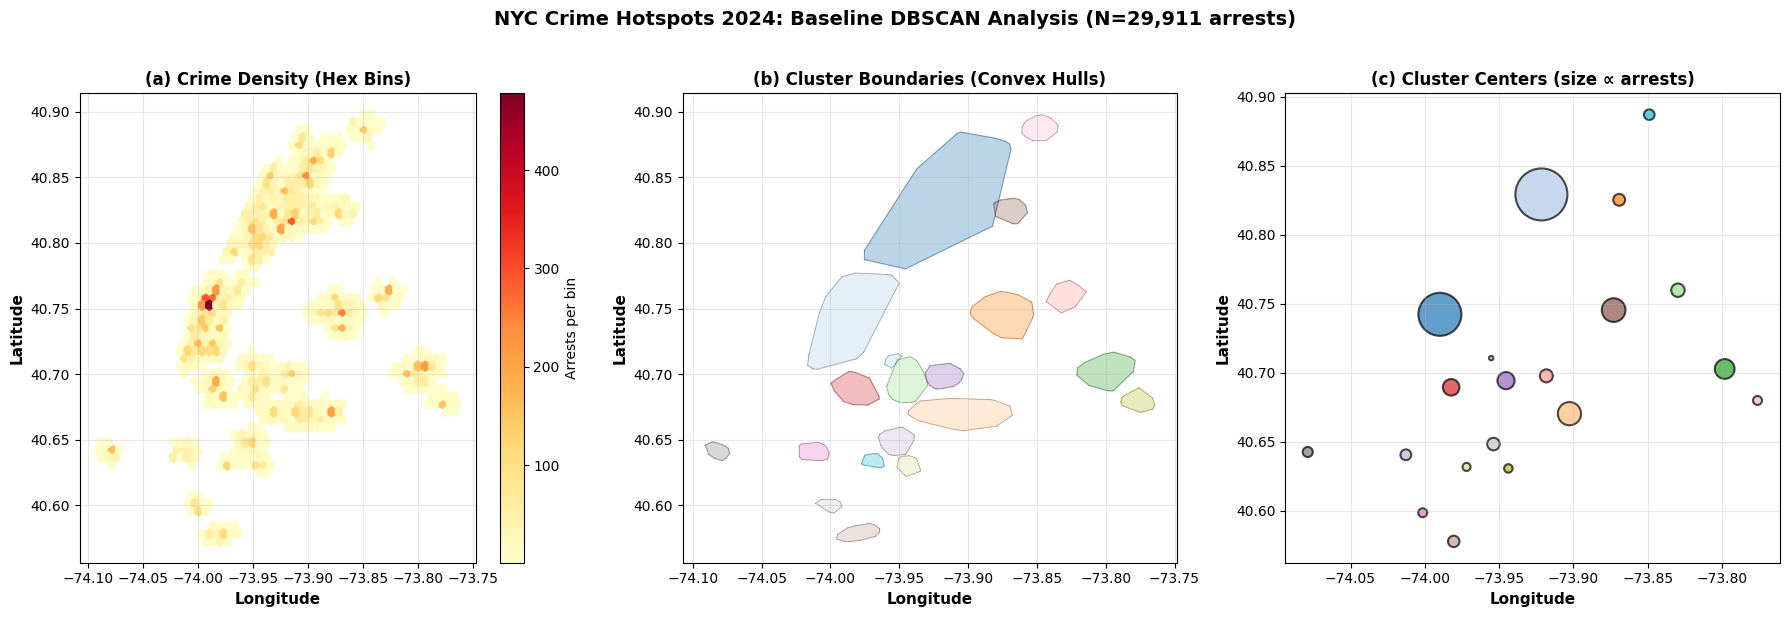

In [14]:
# ========================================
# 11. VISUALIZATION - MULTI-PANEL OVERVIEW
# ========================================

# Prepare data
clustered_data = df_filtered[df_filtered['cluster'] != -1]
cluster_centers = clustered_data.groupby('cluster')[['latitude', 'longitude']].mean()
cluster_center_sizes = clustered_data['cluster'].value_counts()

# Create figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# ===== PANEL (a): DENSITY HEATMAP =====
ax1 = axes[0]
hexbin = ax1.hexbin(clustered_data['longitude'], clustered_data['latitude'],
                    gridsize=50, cmap='YlOrRd', mincnt=1)
ax1.set_xlabel('Longitude', fontweight='bold', fontsize=11)
ax1.set_ylabel('Latitude', fontweight='bold', fontsize=11)
ax1.set_title('(a) Crime Density (Hex Bins)', fontweight='bold', fontsize=12)
ax1.grid(True, alpha=0.3)
cbar1 = plt.colorbar(hexbin, ax=ax1)
cbar1.set_label('Arrests per bin', fontsize=10)

# ===== PANEL (b): CLUSTER BOUNDARIES (CONVEX HULLS) =====
ax2 = axes[1]

# Plot convex hulls for clusters with >= 3 points
colors_list = plt.cm.tab20(np.linspace(0, 1, n_clusters))
color_idx = 0

for cluster_id in cluster_sizes.index[:20]:  # Show top 20 clusters
    cluster_points = clustered_data[clustered_data['cluster'] == cluster_id][['longitude', 'latitude']].values
    
    if len(cluster_points) >= 3:
        try:
            hull = ConvexHull(cluster_points)
            # Plot the convex hull polygon
            for simplex in hull.simplices:
                ax2.plot(cluster_points[simplex, 0], cluster_points[simplex, 1], 
                        'k-', alpha=0.3, linewidth=0.5)
            
            # Fill the polygon
            hull_points = cluster_points[hull.vertices]
            ax2.fill(hull_points[:, 0], hull_points[:, 1], 
                    alpha=0.3, color=colors_list[color_idx % len(colors_list)])
            color_idx += 1
        except:
            pass

ax2.set_xlabel('Longitude', fontweight='bold', fontsize=11)
ax2.set_ylabel('Latitude', fontweight='bold', fontsize=11)
ax2.set_title('(b) Cluster Boundaries (Convex Hulls)', fontweight='bold', fontsize=12)
ax2.grid(True, alpha=0.3)

# ===== PANEL (c): CLUSTER CENTERS =====
ax3 = axes[2]

# Plot cluster centers with size proportional to arrests
sizes = [cluster_center_sizes[cluster_id] / 5 for cluster_id in cluster_centers.index]
scatter = ax3.scatter(cluster_centers['longitude'], cluster_centers['latitude'],
                     s=sizes, c=cluster_centers.index, cmap='tab20',
                     alpha=0.7, edgecolors='black', linewidth=1.5)

ax3.set_xlabel('Longitude', fontweight='bold', fontsize=11)
ax3.set_ylabel('Latitude', fontweight='bold', fontsize=11)
ax3.set_title('(c) Cluster Centers (size ∝ arrests)', fontweight='bold', fontsize=12)
ax3.grid(True, alpha=0.3)

# Overall title
fig.suptitle(f'NYC Crime Hotspots 2024: Baseline DBSCAN Analysis (N={len(df_filtered):,} arrests)', 
            fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.savefig('baseline_dbscan_multipanel.png', dpi=300, bbox_inches='tight')
print("✅ Saved: baseline_dbscan_multipanel.png")
plt.show()

✅ Saved: baseline_clusters_detailed.png (mit NYC Karte)


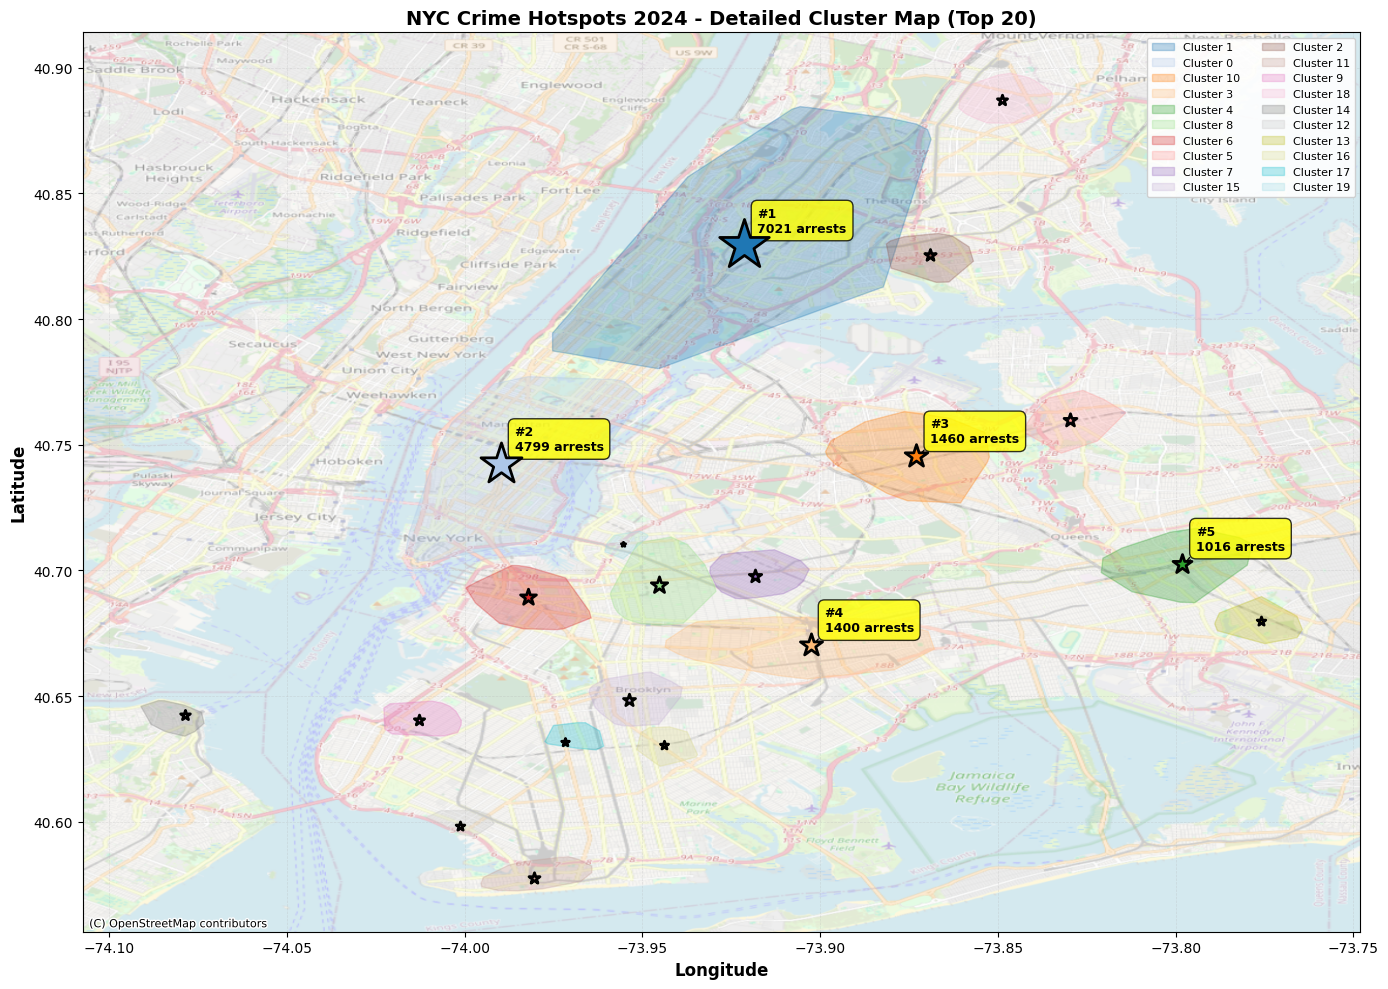

In [15]:
# ========================================
# 12. DETAILED CLUSTER MAP MIT NYC KARTE

fig, ax = plt.subplots(figsize=(14, 10))

# Plot cluster boundaries (convex hulls) for top 20 clusters
colors_list = plt.cm.tab20(np.linspace(0, 1, 20))
for i, cluster_id in enumerate(cluster_sizes.head(20).index):
    cluster_points = clustered_data[clustered_data['cluster'] == cluster_id][['longitude', 'latitude']].values
    
    if len(cluster_points) >= 3:
        try:
            hull = ConvexHull(cluster_points)
            hull_points = cluster_points[hull.vertices]
            ax.fill(hull_points[:, 0], hull_points[:, 1], 
                   alpha=0.3, color=colors_list[i], label=f'Cluster {cluster_id}')
        except:
            pass

# Plot cluster centers as stars
for i, (cluster_id, size) in enumerate(cluster_sizes.head(20).items()):
    center = cluster_centers.loc[cluster_id]
    marker_size = size / 5
    ax.scatter(center['longitude'], center['latitude'],
              s=marker_size, marker='*', c=[colors_list[i]], 
              edgecolors='black', linewidth=2, zorder=5)

# Annotate top 5 clusters
for i, (cluster_id, size) in enumerate(cluster_sizes.head(5).items()):
    center = cluster_centers.loc[cluster_id]
    ax.annotate(f'#{i+1}\n{size} arrests', 
               xy=(center['longitude'], center['latitude']),
               xytext=(10, 10), textcoords='offset points',
               bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.8),
               fontsize=9, fontweight='bold',
               arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# *** NEU: NYC-Karte als Hintergrund hinzufügen ***
ctx.add_basemap(ax, crs='EPSG:4326', 
                source=ctx.providers.OpenStreetMap.Mapnik,
                zoom=12, alpha=0.5)

ax.set_xlabel('Longitude', fontweight='bold', fontsize=12)
ax.set_ylabel('Latitude', fontweight='bold', fontsize=12)
ax.set_title('NYC Crime Hotspots 2024 - Detailed Cluster Map (Top 20)', 
            fontweight='bold', fontsize=14)
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
ax.legend(loc='upper right', fontsize=8, ncol=2, framealpha=0.9)

plt.tight_layout()
plt.savefig('baseline_clusters_detailed.png', dpi=300, bbox_inches='tight')
print("✅ Saved: baseline_clusters_detailed.png (mit NYC Karte)")
plt.show()

In [16]:
# ========================================
# 13. EXPORT CLUSTER STATISTICS TO CSV
# ========================================

# Create comprehensive statistics table for all clusters
cluster_stats_list = []

for cluster_id in cluster_sizes.index:
    cluster_data = clustered_data[clustered_data['cluster'] == cluster_id]
    
    # Basic stats
    n_arrests = len(cluster_data)
    center_lat = cluster_data['latitude'].mean()
    center_lon = cluster_data['longitude'].mean()
    
    # Crime distribution
    crime_counts = cluster_data['ofns_desc'].value_counts()
    dominant_crime = crime_counts.index[0] if len(crime_counts) > 0 else 'Unknown'
    crime_diversity = len(crime_counts)
    
    # Borough (if available)
    if 'arrest_boro' in cluster_data.columns:
        borough_counts = cluster_data['arrest_boro'].value_counts()
        dominant_borough = borough_counts.index[0] if len(borough_counts) > 0 else 'Unknown'
    else:
        dominant_borough = 'N/A'
    
    cluster_stats_list.append({
        'cluster_id': cluster_id,
        'n_arrests': n_arrests,
        'center_latitude': center_lat,
        'center_longitude': center_lon,
        'dominant_crime': dominant_crime,
        'crime_diversity': crime_diversity,
        'dominant_borough': dominant_borough
    })

# Create DataFrame and save
cluster_stats_df = pd.DataFrame(cluster_stats_list)
cluster_stats_df = cluster_stats_df.sort_values('n_arrests', ascending=False)
cluster_stats_df.to_csv('baseline_cluster_statistics.csv', index=False)

print("✅ Saved: baseline_cluster_statistics.csv")
print(f"   Exported statistics for {len(cluster_stats_df)} clusters")
print(f"\nPreview of top 5 clusters:")
print(cluster_stats_df.head())

✅ Saved: baseline_cluster_statistics.csv
   Exported statistics for 20 clusters

Preview of top 5 clusters:
   cluster_id  n_arrests  center_latitude  center_longitude  \
0           1       7021        40.829281        -73.921531   
1           0       4799        40.742372        -73.989862   
2          10       1460        40.745435        -73.872932   
3           3       1400        40.670337        -73.902673   
4           4       1016        40.702752        -73.798211   

                 dominant_crime  crime_diversity dominant_borough  
0  ASSAULT 3 & RELATED OFFENSES                5                B  
1                 PETIT LARCENY                5                M  
2  ASSAULT 3 & RELATED OFFENSES                5                Q  
3  ASSAULT 3 & RELATED OFFENSES                5                K  
4               DANGEROUS DRUGS                5                Q  


In [17]:
# ========================================
# 14. EXPORT SUMMARY REPORT
# ========================================

# Create text summary
summary_lines = []
summary_lines.append("="*80)
summary_lines.append("NYC CRIME HOTSPOTS 2024 - BASELINE DBSCAN ANALYSIS SUMMARY")
summary_lines.append("="*80)
summary_lines.append("")
summary_lines.append(f"Analysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")
summary_lines.append(f"Data Period: 2024 (Full Year)")
summary_lines.append("")
summary_lines.append("DBSCAN PARAMETERS:")
summary_lines.append(f"  • eps = {eps} radians (~500m)")
summary_lines.append(f"  • min_samples = {min_samples}")
summary_lines.append(f"  • metric = haversine")
summary_lines.append("")
summary_lines.append("OVERALL STATISTICS:")
summary_lines.append(f"  • Total arrests analyzed: {len(df_filtered):,}")
summary_lines.append(f"  • Crime categories: {len(relevant_crimes)}")
summary_lines.append(f"  • Clusters identified: {n_clusters}")
summary_lines.append(f"  • Clustered arrests: {n_clustered:,} ({(n_clustered/len(clusters)*100):.1f}%)")
summary_lines.append(f"  • Noise points: {n_noise:,} ({noise_percent:.1f}%)")
summary_lines.append("")
summary_lines.append("CLUSTER SIZE DISTRIBUTION:")
summary_lines.append(f"  • Average: {avg_cluster_size:.1f} arrests")
summary_lines.append(f"  • Median: {median_cluster_size:.1f} arrests")
summary_lines.append(f"  • Range: {min_cluster_size} - {max_cluster_size} arrests")
summary_lines.append(f"  • Std Dev: {std_cluster_size:.1f}")
summary_lines.append("")
summary_lines.append("TOP 5 HOTSPOTS:")
for i, (cluster_id, size) in enumerate(cluster_sizes.head(5).items(), 1):
    cluster_data = clustered_data[clustered_data['cluster'] == cluster_id]
    center_lat = cluster_data['latitude'].mean()
    center_lon = cluster_data['longitude'].mean()
    dominant_crime = cluster_data['ofns_desc'].mode()[0]
    summary_lines.append(f"  {i}. Cluster #{cluster_id}: {size:,} arrests at ({center_lat:.4f}, {center_lon:.4f})")
    summary_lines.append(f"     Dominant Crime: {dominant_crime}")
summary_lines.append("")
summary_lines.append("CRIME TYPE CLUSTERING:")
for crime in relevant_crimes:
    n_total = len(df_filtered[df_filtered['ofns_desc'] == crime])
    n_clustered_crime = len(clustered_data[clustered_data['ofns_desc'] == crime])
    cluster_pct = (n_clustered_crime / n_total * 100) if n_total > 0 else 0
    summary_lines.append(f"  • {crime}: {cluster_pct:.1f}% clustered")
summary_lines.append("")
summary_lines.append("OUTPUT FILES:")
summary_lines.append("  1. baseline_dbscan_multipanel.png - Main visualization figure")
summary_lines.append("  2. baseline_clusters_detailed.png - Detailed cluster map")
summary_lines.append("  3. baseline_cluster_statistics.csv - Complete cluster statistics")
summary_lines.append("  4. baseline_summary.txt - This summary report")
summary_lines.append("")
summary_lines.append("="*80)
summary_lines.append("ANALYSIS COMPLETED SUCCESSFULLY")
summary_lines.append("="*80)

# Save to file
summary_text = "\n".join(summary_lines)
with open('baseline_summary.txt', 'w') as f:
    f.write(summary_text)

print("✅ Saved: baseline_summary.txt")
print("\n" + summary_text)

✅ Saved: baseline_summary.txt

NYC CRIME HOTSPOTS 2024 - BASELINE DBSCAN ANALYSIS SUMMARY

Analysis Date: 2025-11-29 22:09:40
Data Period: 2024 (Full Year)

DBSCAN PARAMETERS:
  • eps = 0.0001 radians (~500m)
  • min_samples = 150
  • metric = haversine

OVERALL STATISTICS:
  • Total arrests analyzed: 29,911
  • Crime categories: 5
  • Clusters identified: 20
  • Clustered arrests: 571 (1.9%)
  • Noise points: 255 (30.2%)

CLUSTER SIZE DISTRIBUTION:
  • Average: 1044.5 arrests
  • Median: 388.0 arrests
  • Range: 51 - 7021 arrests
  • Std Dev: 1746.6

TOP 5 HOTSPOTS:
  1. Cluster #1: 7,021 arrests at (40.8293, -73.9215)
     Dominant Crime: ASSAULT 3 & RELATED OFFENSES
  2. Cluster #0: 4,799 arrests at (40.7424, -73.9899)
     Dominant Crime: PETIT LARCENY
  3. Cluster #10: 1,460 arrests at (40.7454, -73.8729)
     Dominant Crime: ASSAULT 3 & RELATED OFFENSES
  4. Cluster #3: 1,400 arrests at (40.6703, -73.9027)
     Dominant Crime: ASSAULT 3 & RELATED OFFENSES
  5. Cluster #4: 1,016 a